In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip -q install transformers timm pycocotools

import os, json, time, math, random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5.5 MB/s eta 0:00:000:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installe

In [2]:
ROOT = "/kaggle/input/solesensei_bdd100k"

IMG_DIR_TRAIN = os.path.join(ROOT, "bdd100k", "bdd100k", "images", "100k", "train")
IMG_DIR_VAL   = os.path.join(ROOT, "bdd100k", "bdd100k", "images", "100k", "val")

LABEL_DIR = os.path.join(ROOT, "bdd100k_labels_release", "bdd100k", "labels")
BDD_LABEL_TRAIN = os.path.join(LABEL_DIR, "bdd100k_labels_images_train.json")
BDD_LABEL_VAL   = os.path.join(LABEL_DIR, "bdd100k_labels_images_val.json")

print("IMG train:", os.path.exists(IMG_DIR_TRAIN))
print("IMG val  :", os.path.exists(IMG_DIR_VAL))
print("LBL train:", os.path.exists(BDD_LABEL_TRAIN))
print("LBL val  :", os.path.exists(BDD_LABEL_VAL))


IMG train: True
IMG val  : True
LBL train: True
LBL val  : True


In [3]:
COCO_TRAIN_JSON = "/kaggle/working/bdd_train_coco.json"
COCO_VAL_JSON   = "/kaggle/working/bdd_val_coco.json"

MAX_TRAIN_IMAGES = 2000
MAX_VAL_IMAGES   = 500

BDD_CATS = ["person","rider","car","truck","bus","train","motorcycle","bicycle","traffic light","traffic sign"]
BDD2ID = {n: i+1 for i, n in enumerate(BDD_CATS)}  # 1..10

def bdd_to_coco(bdd_json_path, img_dir, out_json_path, max_images=None):
    with open(bdd_json_path, "r") as f:
        data = json.load(f)

    images, annotations = [], []
    ann_id = 1
    img_id = 1
    existing = set(os.listdir(img_dir))

    for item in data:
        fname = item.get("name","")
        if fname not in existing:
            continue

        w, h = Image.open(os.path.join(img_dir, fname)).size  # ✅ real size

        images.append({"id": img_id, "file_name": fname, "width": w, "height": h})

        for lab in item.get("labels", []):
            cat = lab.get("category","")
            if cat not in BDD2ID:
                continue
            box = lab.get("box2d")
            if box is None:
                continue

            x1,y1,x2,y2 = float(box["x1"]),float(box["y1"]),float(box["x2"]),float(box["y2"])
            bw,bh = max(0.0,x2-x1), max(0.0,y2-y1)
            if bw < 1 or bh < 1:
                continue

            attrs = lab.get("attributes", {})
            occluded  = float(attrs.get("occluded", 0.0))
            truncated = float(attrs.get("truncated", 0.0))

            annotations.append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": BDD2ID[cat],     # 1..10 ✅
                "bbox": [x1,y1,bw,bh],          # xywh ✅
                "area": bw*bh,
                "iscrowd": 0,
                "occluded_flag": occluded,
                "truncated_flag": truncated
            })
            ann_id += 1

        img_id += 1
        if max_images and len(images) >= max_images:
            break

    coco = {
        "info": {"description":"BDD100K->COCO (10 classes)", "version":"1.0"},
        "licenses": [],
        "images": images,
        "annotations": annotations,
        "categories": [{"id": BDD2ID[n], "name": n} for n in BDD_CATS],
    }

    with open(out_json_path, "w") as f:
        json.dump(coco, f)

    print(f"✅ Saved {out_json_path} | images={len(images)} anns={len(annotations)}")

bdd_to_coco(BDD_LABEL_TRAIN, IMG_DIR_TRAIN, COCO_TRAIN_JSON, max_images=MAX_TRAIN_IMAGES)
bdd_to_coco(BDD_LABEL_VAL,   IMG_DIR_VAL,   COCO_VAL_JSON,   max_images=MAX_VAL_IMAGES)


✅ Saved /kaggle/working/bdd_train_coco.json | images=1154 anns=20820
✅ Saved /kaggle/working/bdd_val_coco.json | images=500 anns=9275


In [6]:
class BDDCocoDataset(Dataset):
    def __init__(self, img_dir, coco_json):
        self.img_dir = img_dir
        self.coco = COCO(coco_json)
        self.ids = list(self.coco.imgs.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, info["file_name"])
        img = Image.open(img_path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)

        boxes_xywh = np.array([a["bbox"] for a in anns], dtype=np.float32) if len(anns) else np.zeros((0,4), np.float32)
        labels = np.array([a["category_id"] for a in anns], dtype=np.int64) if len(anns) else np.zeros((0,), np.int64)

        # COCO 1..10 -> HF expects 0..9
        labels = labels - 1

        # visibility
        occ = np.array([a.get("occluded_flag",0.0) for a in anns], dtype=np.float32) if len(anns) else np.zeros((0,), np.float32)
        visibility = 1.0 - occ

        target = {
            "image_id": img_id,
            "boxes_xywh": boxes_xywh,   # absolute xywh
            "labels": labels,           # 0..9
            "visibility": visibility,
            "size": (info["height"], info["width"])
        }
        return img, target


In [7]:
from transformers import DetrForObjectDetection, DetrImageProcessor

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

def collate_fn(batch):
    imgs = [b[0] for b in batch]
    targets = [b[1] for b in batch]

    enc = processor(images=imgs, return_tensors="pt")

    detr_targets = []
    orig_targets = []
    sizes = []

    for t in targets:
        h, w = t["size"]
        boxes = torch.tensor(t["boxes_xywh"], dtype=torch.float32)
        # xywh -> cxcywh normalized
        if boxes.numel() > 0:
            x,y,bw,bh = boxes[:,0],boxes[:,1],boxes[:,2],boxes[:,3]
            cx = x + bw/2
            cy = y + bh/2
            boxes = torch.stack([cx/w, cy/h, bw/w, bh/h], dim=1).clamp(0,1)

        labels = torch.tensor(t["labels"], dtype=torch.int64)

        detr_targets.append({"class_labels": labels, "boxes": boxes})
        orig_targets.append(t)
        sizes.append((h,w))

    return enc, detr_targets, orig_targets, sizes


2025-12-23 16:26:49.618316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766507209.815362      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766507209.868648      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

In [8]:
train_ds = BDDCocoDataset(IMG_DIR_TRAIN, COCO_TRAIN_JSON)
val_ds   = BDDCocoDataset(IMG_DIR_VAL,   COCO_VAL_JSON)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)

baseline_detr = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", ignore_mismatched_sizes=True).to(DEVICE)
baseline_detr.config.num_labels = 10
in_features = baseline_detr.class_labels_classifier.in_features
baseline_detr.class_labels_classifier = torch.nn.Linear(in_features, 11).to(DEVICE)

opt = torch.optim.AdamW(baseline_detr.parameters(), lr=5e-5, weight_decay=1e-4)
print("✅ model + loaders ready")


loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

✅ model + loaders ready


In [9]:
def train_one_epoch(model, loader):
    model.train()
    total, n = 0, 0
    for enc, detr_targets, _, _ in loader:
        pv = enc["pixel_values"].to(DEVICE)
        pm = enc["pixel_mask"].to(DEVICE)
        detr_targets = [{k:v.to(DEVICE) for k,v in t.items()} for t in detr_targets]

        opt.zero_grad(set_to_none=True)
        out = model(pixel_values=pv, pixel_mask=pm, labels=detr_targets)
        out.loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        total += float(out.loss.item()); n += 1
    return total/max(1,n)

for e in range(1,3):
    loss = train_one_epoch(baseline_detr, train_loader)
    print("Epoch", e, "loss", loss)


Epoch 1 loss 3.08527554238483
Epoch 2 loss 2.5976497238595524


In [10]:
def xyxy_to_xywh(b):
    x1,y1,x2,y2 = b
    return [float(x1), float(y1), float(x2-x1), float(y2-y1)]

@torch.no_grad()
def coco_map(model, loader, coco_gt, score_thr=0.05):
    model.eval()
    results = []

    for enc, _detr_targets, orig_targets, sizes in loader:
        pv = enc["pixel_values"].to(DEVICE)
        pm = enc["pixel_mask"].to(DEVICE)
        out = model(pixel_values=pv, pixel_mask=pm)

        target_sizes = torch.tensor(sizes, dtype=torch.long).to(DEVICE)
        preds = processor.post_process_object_detection(out, target_sizes=target_sizes, threshold=score_thr)

        for pred, gt in zip(preds, orig_targets):
            img_id = int(gt["image_id"])
            boxes = pred["boxes"].cpu().numpy()
            scores = pred["scores"].cpu().numpy()
            labels = pred["labels"].cpu().numpy() + 1  # back to 1..10 for COCO

            for b,s,c in zip(boxes, scores, labels):
                results.append({
                    "image_id": img_id,
                    "category_id": int(c),
                    "bbox": xyxy_to_xywh(b),
                    "score": float(s)
                })

    coco_dt = coco_gt.loadRes(results)
    ev = COCOeval(coco_gt, coco_dt, "bbox")
    ev.evaluate(); ev.accumulate(); ev.summarize()
    return {"AP": float(ev.stats[0]), "AP50": float(ev.stats[1]), "AP75": float(ev.stats[2])}

coco_val = COCO(COCO_VAL_JSON)
print("✅ COCO mAP baseline:", coco_map(baseline_detr, val_loader, coco_val))


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=6.21s).
Accumulating evaluation results...
DONE (t=0.45s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.058
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.040
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------- OAM + DAF ----------
class OAM(nn.Module):
    """Occlusion Attention Module: predicts visibility map (B,1,H,W) from a feature map."""
    def __init__(self, c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(c, c, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(c, 1, 1)
        )

    def forward(self, feat):
        vis_map = torch.sigmoid(self.net(feat))  # 1=visible, 0=occluded
        f_vis = feat * vis_map
        f_occ = feat * (1.0 - vis_map)
        return f_vis, f_occ, vis_map


class DAF(nn.Module):
    """Dual Attention Fusion: learns a gate to blend visible/occluded feature streams."""
    def __init__(self, c):
        super().__init__()
        self.gate = nn.Sequential(
            nn.Conv2d(2*c, c, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(c, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, f_vis, f_occ):
        g = self.gate(torch.cat([f_vis, f_occ], dim=1))  # (B,1,H,W)
        fused = g * f_vis + (1.0 - g) * f_occ
        return fused, g


class OcaHead(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.oam = OAM(c)
        self.daf = DAF(c)

    def forward(self, feat):
        f_vis, f_occ, vis_map = self.oam(feat)
        fused, gate = self.daf(f_vis, f_occ)
        return fused, vis_map, gate


# ---------- OcaDETR Wrapper ----------
class OcaDETRLite(nn.Module):
    """
    Wraps HF DETR. Adds:
      - OAM visibility map supervision
      - DAF gate map for explainability
    Total loss = DETR loss + lambda_occ * occ_loss
    """
    def __init__(self, detr_model, feat_channels=2048):
        super().__init__()
        self.detr = detr_model
        self.occ_head = OcaHead(feat_channels)

    def forward(self, pixel_values, pixel_mask, labels=None, orig_targets=None, lambda_occ=0.0):
        # DETR forward (detection)
        out = self.detr(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        # Backbone conv features
        backbone = self.detr.model.backbone
        feats, _pos = backbone(pixel_values, pixel_mask)

        last = feats[-1]
        if isinstance(last, (list, tuple)):
            feat = last[0]
        elif hasattr(last, "tensors"):
            feat = last.tensors
        else:
            feat = last  # Tensor

        # OAM + DAF
        _fused, vis_map, gate = self.occ_head(feat)

        # Occlusion supervision loss
        occ_loss = None
        if (orig_targets is not None) and (lambda_occ > 0):
            B, _, Hf, Wf = vis_map.shape
            losses = []

            for b in range(B):
                gt = orig_targets[b]
                boxes = torch.tensor(gt["boxes_xywh"], dtype=torch.float32, device=vis_map.device)
                if boxes.numel() == 0:
                    continue

                ih, iw = gt["size"]  # (H,W)
                sx, sy = Wf / iw, Hf / ih
                vis_arr = gt["visibility"]

                for i in range(boxes.shape[0]):
                    x, y, w, h = boxes[i]

                    x0 = int(torch.clamp(x * sx, 0, Wf - 1).item())
                    y0 = int(torch.clamp(y * sy, 0, Hf - 1).item())
                    x1 = int(torch.clamp((x + w) * sx, 0, Wf).item())
                    y1 = int(torch.clamp((y + h) * sy, 0, Hf).item())

                    if x1 <= x0 or y1 <= y0:
                        continue

                    region = vis_map[b, 0, y0:y1, x0:x1]
                    vis_t = float(vis_arr[i]) if i < len(vis_arr) else 1.0
                    losses.append((region.mean() - vis_t) ** 2)

            occ_loss = torch.stack(losses).mean() if len(losses) else torch.tensor(0.0, device=vis_map.device)

        # Total loss
        total_loss = out.loss
        if occ_loss is not None:
            total_loss = total_loss + lambda_occ * occ_loss

        extras = {"vis_map": vis_map.detach(), "gate": gate.detach()}
        return total_loss, out, extras, occ_loss


oca_model = OcaDETRLite(baseline_detr, feat_channels=2048).to(DEVICE)
oca_opt = torch.optim.AdamW(oca_model.parameters(), lr=3e-5, weight_decay=1e-4)
print("✅ OcaDETR-Lite ready")


✅ OcaDETR-Lite ready


In [23]:
def train_one_epoch_oca(model, loader, optimizer, lambda_occ=0.0, log_every=200):
    model.train()
    total, n = 0.0, 0
    for step,(enc, detr_targets, orig_targets, _sizes) in enumerate(loader, start=1):
        pv = enc["pixel_values"].to(DEVICE)
        pm = enc["pixel_mask"].to(DEVICE)
        detr_targets = [{k:v.to(DEVICE) for k,v in t.items()} for t in detr_targets]

        optimizer.zero_grad(set_to_none=True)
        loss, _out, _extras, occ_loss = model(pv, pm, labels=detr_targets, orig_targets=orig_targets, lambda_occ=lambda_occ)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total += float(loss.item()); n += 1
        if step % log_every == 0:
            ol = float(occ_loss.item()) if occ_loss is not None else 0.0
            print(f"[oca] step {step}/{len(loader)} loss={loss.item():.4f} occ={ol:.4f}")

    return total/max(1,n)

# Warmup schedule (very important)
lambda_schedule = [0.0, 0.5, 1.0, 2.0]

for e, lam in enumerate(lambda_schedule, start=1):
    tr = train_one_epoch_oca(oca_model, train_loader, oca_opt, lambda_occ=lam, log_every=200)
    print(f"Epoch {e} done | lambda_occ={lam} | train_loss={tr:.4f}")


[oca] step 200/577 loss=2.2900 occ=0.0000
[oca] step 400/577 loss=1.9182 occ=0.0000
Epoch 1 done | lambda_occ=0.0 | train_loss=2.2919
[oca] step 200/577 loss=1.6807 occ=0.1204
[oca] step 400/577 loss=2.2228 occ=0.1377
Epoch 2 done | lambda_occ=0.5 | train_loss=2.2305
[oca] step 200/577 loss=2.7419 occ=0.2092
[oca] step 400/577 loss=2.7022 occ=0.1034
Epoch 3 done | lambda_occ=1.0 | train_loss=2.2423
[oca] step 200/577 loss=2.6436 occ=0.0904
[oca] step 400/577 loss=2.0895 occ=0.1024
Epoch 4 done | lambda_occ=2.0 | train_loss=2.2937


In [24]:
enc, detr_targets, orig_targets, sizes = next(iter(train_loader))
pv = enc["pixel_values"].to(DEVICE)
pm = enc["pixel_mask"].to(DEVICE)
loss, out, extras, occ_loss = oca_model(pv, pm, labels=[{k:v.to(DEVICE) for k,v in t.items()} for t in detr_targets], orig_targets=orig_targets, lambda_occ=0.5)
print("loss:", loss.item(), "occ_loss:", float(occ_loss))
print("vis_map:", extras["vis_map"].shape, "gate:", extras["gate"].shape)


loss: 1.8459408283233643 occ_loss: 0.08342397212982178
vis_map: torch.Size([2, 1, 24, 42]) gate: torch.Size([2, 1, 24, 42])


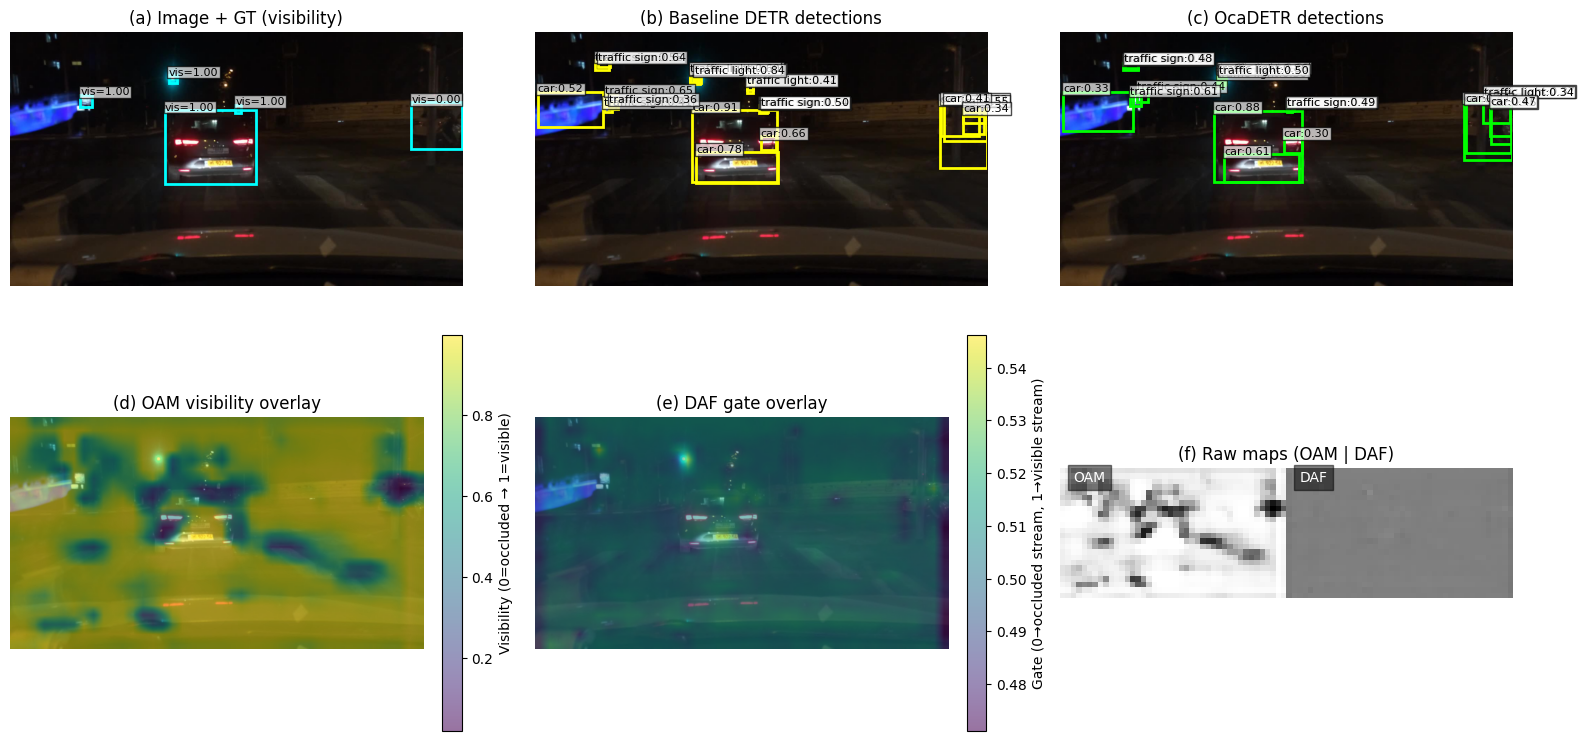

✅ Saved: /kaggle/working/ocadetr_explainability.png


In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch

def draw_boxes(ax, boxes_xyxy, labels, scores=None, label_names=None, color="lime", lw=2):
    for i, b in enumerate(boxes_xyxy):
        x1,y1,x2,y2 = b
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=lw, edgecolor=color, facecolor="none")
        ax.add_patch(rect)
        txt = ""
        if label_names is not None:
            txt += label_names[int(labels[i])]
        else:
            txt += str(int(labels[i]))
        if scores is not None:
            txt += f":{scores[i]:.2f}"
        ax.text(x1, y1, txt, color="black",
                bbox=dict(facecolor="white", alpha=0.7, pad=1), fontsize=8)

@torch.no_grad()
def visualize_ocadetr(idx=5, score_thr=0.3, save_path="/kaggle/working/ocadetr_explainability.png"):
    # --- get one val sample ---
    img, tgt = val_ds[idx]
    ih, iw = tgt["size"]
    img_np = np.array(img)

    # --- make a single-item batch ---
    enc = processor(images=[img], return_tensors="pt")
    pv = enc["pixel_values"].to(DEVICE)
    pm = enc["pixel_mask"].to(DEVICE)

    # --- baseline predictions ---
    base_out = baseline_detr(pixel_values=pv, pixel_mask=pm)
    base_pred = processor.post_process_object_detection(
        base_out, target_sizes=torch.tensor([[ih, iw]]).to(DEVICE), threshold=score_thr
    )[0]

    # --- oca predictions + maps ---
    # IMPORTANT: lambda_occ=0 for visualization (we only want maps, no added loss)
    loss, out, extras, occ_loss = oca_model(pv, pm, labels=None, orig_targets=[tgt], lambda_occ=0.0)
    oca_pred = processor.post_process_object_detection(
        out, target_sizes=torch.tensor([[ih, iw]]).to(DEVICE), threshold=score_thr
    )[0]

    vis_map = extras["vis_map"][0,0].float().cpu().numpy()   # (Hf,Wf)
    gate_map = extras["gate"][0,0].float().cpu().numpy()     # (Hf,Wf)

    # upsample maps to image size for overlay
    vis_up = torch.tensor(vis_map)[None,None,:,:]
    gate_up = torch.tensor(gate_map)[None,None,:,:]
    vis_up = torch.nn.functional.interpolate(vis_up, size=(ih, iw), mode="bilinear", align_corners=False)[0,0].numpy()
    gate_up = torch.nn.functional.interpolate(gate_up, size=(ih, iw), mode="bilinear", align_corners=False)[0,0].numpy()

    # --- GT boxes + visibility labels ---
    gt_xywh = tgt["boxes_xywh"]
    gt_xyxy = []
    for x,y,w,h in gt_xywh:
        gt_xyxy.append([x,y,x+w,y+h])
    gt_xyxy = np.array(gt_xyxy, dtype=np.float32)
    gt_vis = tgt["visibility"]

    # --- plot ---
    fig = plt.figure(figsize=(16, 8))
    gs = fig.add_gridspec(2, 3, height_ratios=[1,1])

    # (a) image + GT + visibility
    ax1 = fig.add_subplot(gs[0,0])
    ax1.imshow(img_np)
    ax1.set_title("(a) Image + GT (visibility)")
    ax1.axis("off")
    for i,b in enumerate(gt_xyxy):
        x1,y1,x2,y2 = b
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor="cyan", facecolor="none")
        ax1.add_patch(rect)
        ax1.text(x1, y1, f"vis={gt_vis[i]:.2f}", color="black",
                 bbox=dict(facecolor="white", alpha=0.7, pad=1), fontsize=8)

    # (b) baseline detections
    ax2 = fig.add_subplot(gs[0,1])
    ax2.imshow(img_np)
    ax2.set_title("(b) Baseline DETR detections")
    ax2.axis("off")
    if len(base_pred["boxes"]) > 0:
        draw_boxes(ax2,
                   base_pred["boxes"].cpu().numpy(),
                   base_pred["labels"].cpu().numpy(),
                   base_pred["scores"].cpu().numpy(),
                   label_names=BDD_CATS,
                   color="yellow")

    # (c) oca detections
    ax3 = fig.add_subplot(gs[0,2])
    ax3.imshow(img_np)
    ax3.set_title("(c) OcaDETR detections")
    ax3.axis("off")
    if len(oca_pred["boxes"]) > 0:
        draw_boxes(ax3,
                   oca_pred["boxes"].cpu().numpy(),
                   oca_pred["labels"].cpu().numpy(),
                   oca_pred["scores"].cpu().numpy(),
                   label_names=BDD_CATS,
                   color="lime")

    # (d) OAM visibility overlay
    ax4 = fig.add_subplot(gs[1,0])
    ax4.imshow(img_np)
    hm1 = ax4.imshow(vis_up, alpha=0.55)
    ax4.set_title("(d) OAM visibility overlay")
    ax4.axis("off")
    cbar1 = fig.colorbar(hm1, ax=ax4, fraction=0.046, pad=0.04)
    cbar1.set_label("Visibility (0=occluded → 1=visible)")

    # (e) DAF gate overlay
    ax5 = fig.add_subplot(gs[1,1])
    ax5.imshow(img_np)
    hm2 = ax5.imshow(gate_up, alpha=0.55)
    ax5.set_title("(e) DAF gate overlay")
    ax5.axis("off")
    cbar2 = fig.colorbar(hm2, ax=ax5, fraction=0.046, pad=0.04)
    cbar2.set_label("Gate (0→occluded stream, 1→visible stream)")

    # (f) raw maps
    ax6 = fig.add_subplot(gs[1,2])
    ax6.set_title("(f) Raw maps (OAM | DAF)")
    ax6.axis("off")
    combo = np.concatenate([vis_map, gate_map], axis=1)
    ax6.imshow(combo, cmap="gray")
    ax6.text(2, 2, "OAM", color="white", fontsize=10, bbox=dict(facecolor="black", alpha=0.5))
    ax6.text(vis_map.shape[1]+2, 2, "DAF", color="white", fontsize=10, bbox=dict(facecolor="black", alpha=0.5))

    plt.tight_layout()
    plt.savefig(save_path, dpi=200)
    plt.show()
    print("✅ Saved:", save_path)

visualize_ocadetr(idx=5, score_thr=0.3, save_path="/kaggle/working/ocadetr_explainability.png")


In [26]:
import os
print("\n".join(sorted(os.listdir("/kaggle/working"))))


.virtual_documents
bdd_train_coco.json
bdd_val_coco.json
ocadetr_explainability.png


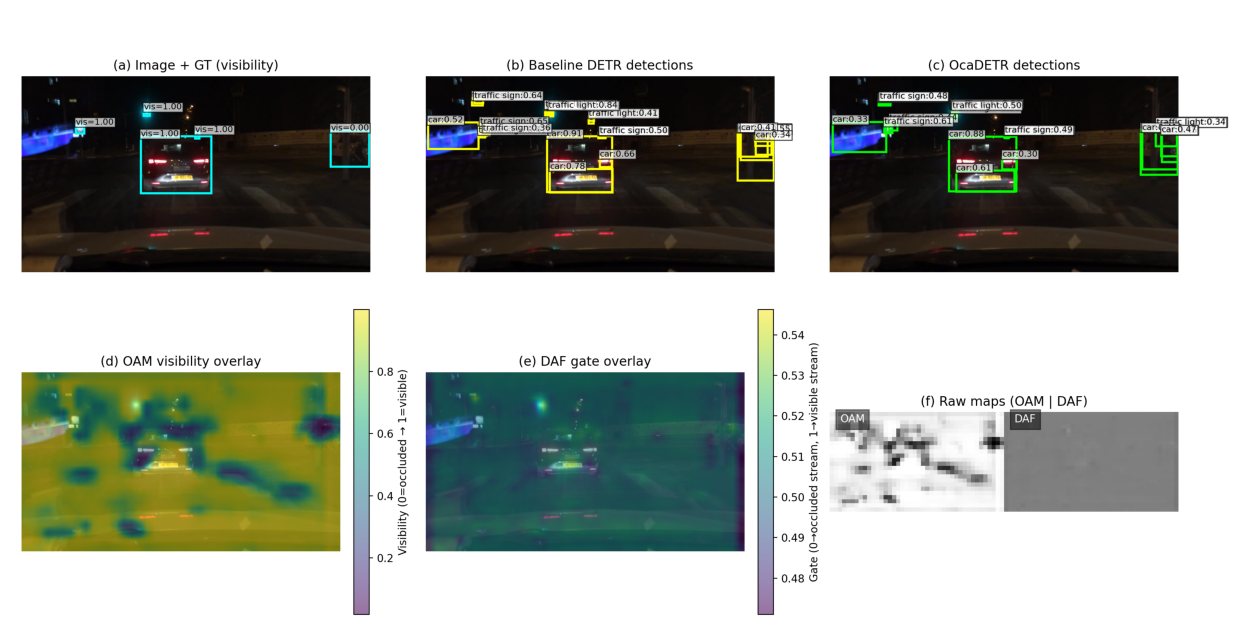

In [27]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("/kaggle/working/ocadetr_explainability.png")
plt.figure(figsize=(16,8))
plt.imshow(img)
plt.axis("off")
plt.show()


In [28]:
import numpy as np

def occlusion_score(tgt):
    # lower visibility => more occlusion
    v = np.array(tgt["visibility"], dtype=np.float32) if len(tgt["visibility"]) else np.array([1.0], np.float32)
    return float(1.0 - v.min())  # max occlusion in image

scores = []
for i in range(len(val_ds)):
    _img, tgt = val_ds[i]
    s = occlusion_score(tgt)
    scores.append((s, i, len(tgt["visibility"])))

scores.sort(reverse=True)  # most occluded first
top = scores[:10]

print("Top 10 most-occluded samples (score, idx, num_objects):")
for s, idx, n in top:
    print(f"score={s:.3f} idx={idx} objs={n}")

best_indices = [idx for _, idx, _ in top[:3]]
print("\n✅ Will generate figures for indices:", best_indices)


Top 10 most-occluded samples (score, idx, num_objects):
score=1.000 idx=499 objs=9
score=1.000 idx=498 objs=4
score=1.000 idx=497 objs=12
score=1.000 idx=496 objs=17
score=1.000 idx=495 objs=25
score=1.000 idx=494 objs=32
score=1.000 idx=493 objs=29
score=1.000 idx=492 objs=53
score=1.000 idx=491 objs=20
score=1.000 idx=490 objs=17

✅ Will generate figures for indices: [499, 498, 497]


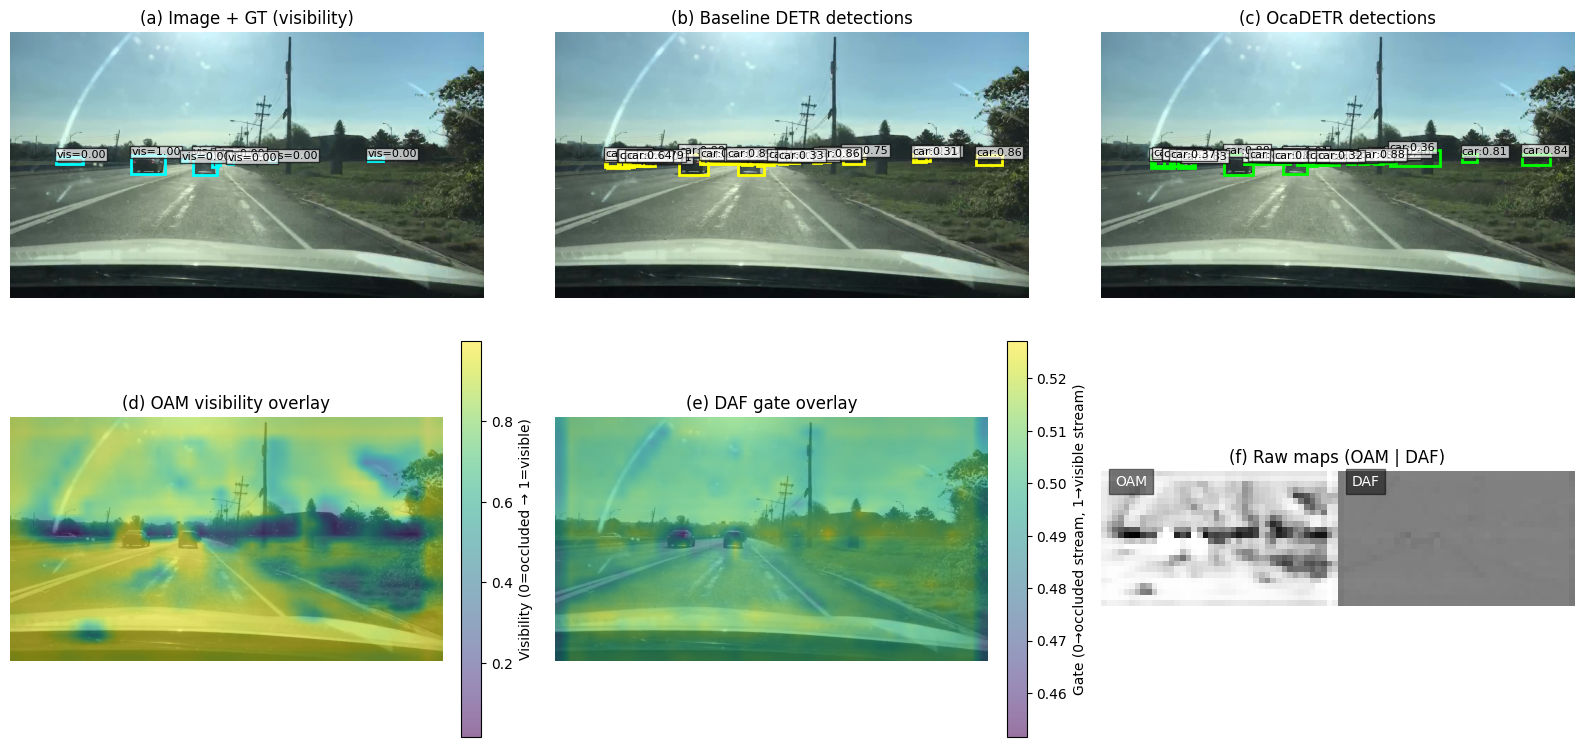

✅ Saved: /kaggle/working/ocadetr_explainability_best1_idx499.png


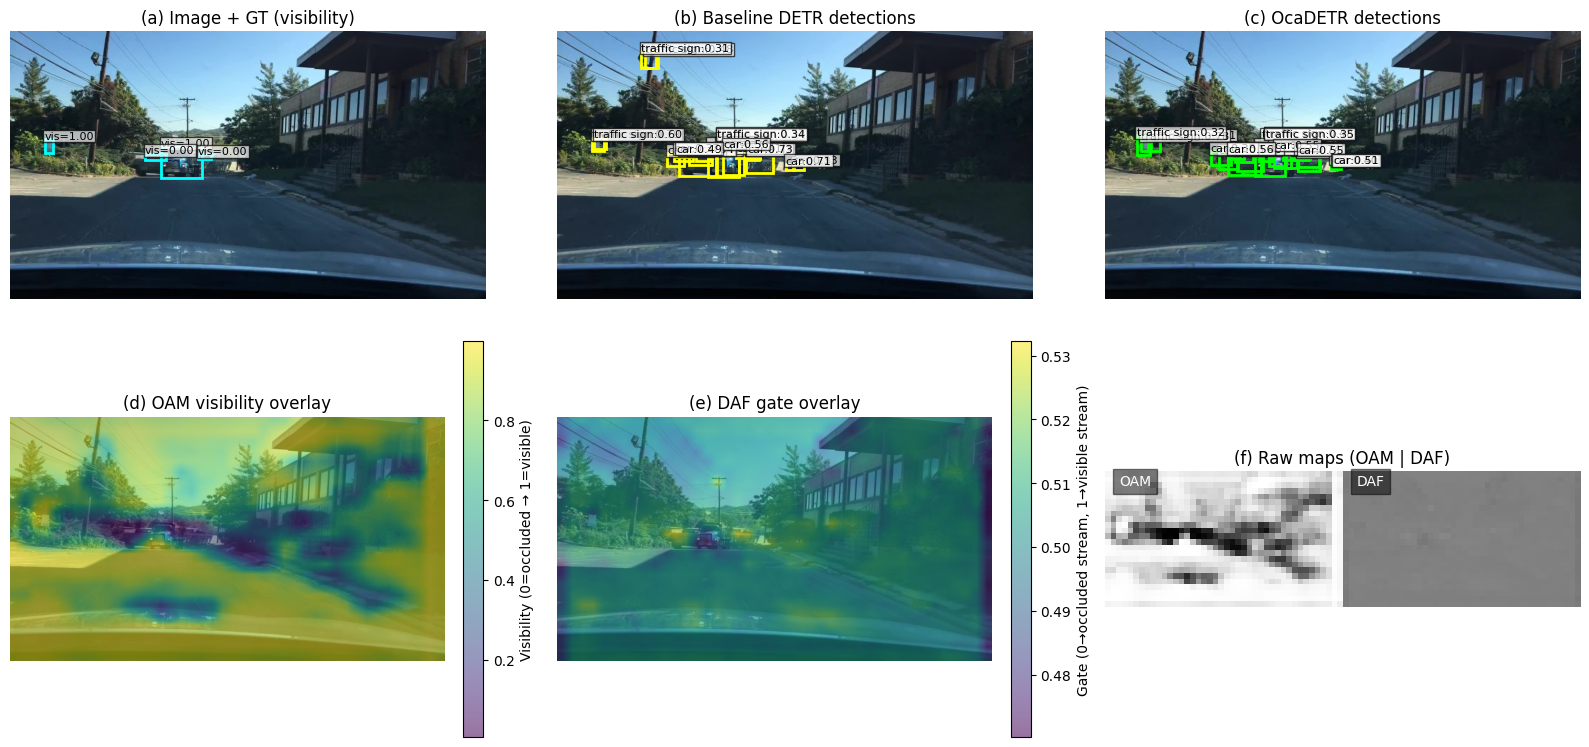

✅ Saved: /kaggle/working/ocadetr_explainability_best2_idx498.png


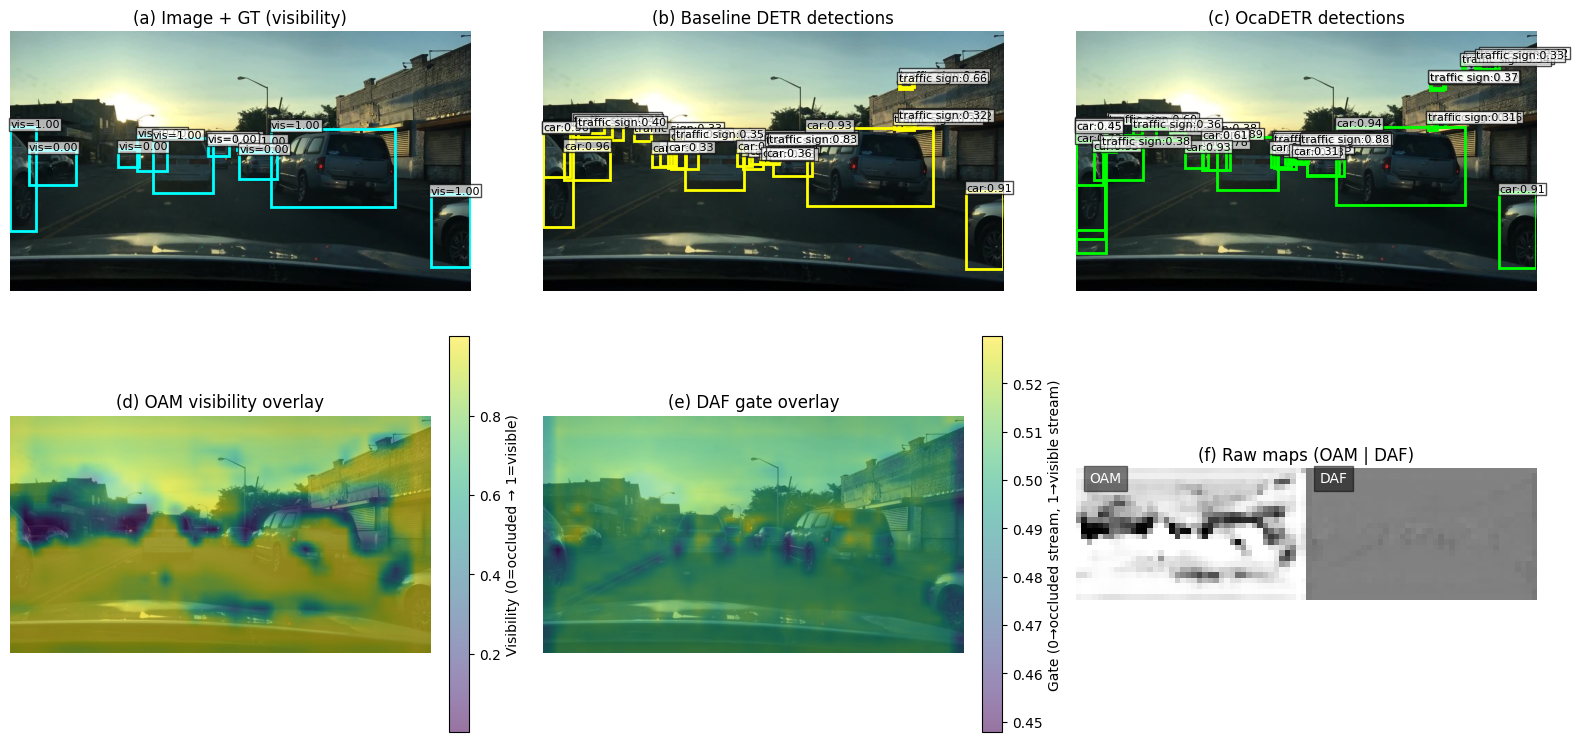

✅ Saved: /kaggle/working/ocadetr_explainability_best3_idx497.png

✅ Saved files in /kaggle/working:
 - ocadetr_explainability_best1_idx499.png
 - ocadetr_explainability_best2_idx498.png
 - ocadetr_explainability_best3_idx497.png


In [29]:
# Generate 3 figures (most occluded)
for k, idx in enumerate(best_indices, start=1):
    save_path = f"/kaggle/working/ocadetr_explainability_best{k}_idx{idx}.png"
    visualize_ocadetr(idx=idx, score_thr=0.3, save_path=save_path)

print("\n✅ Saved files in /kaggle/working:")
import os
for f in sorted(os.listdir("/kaggle/working")):
    if "ocadetr_explainability_best" in f:
        print(" -", f)


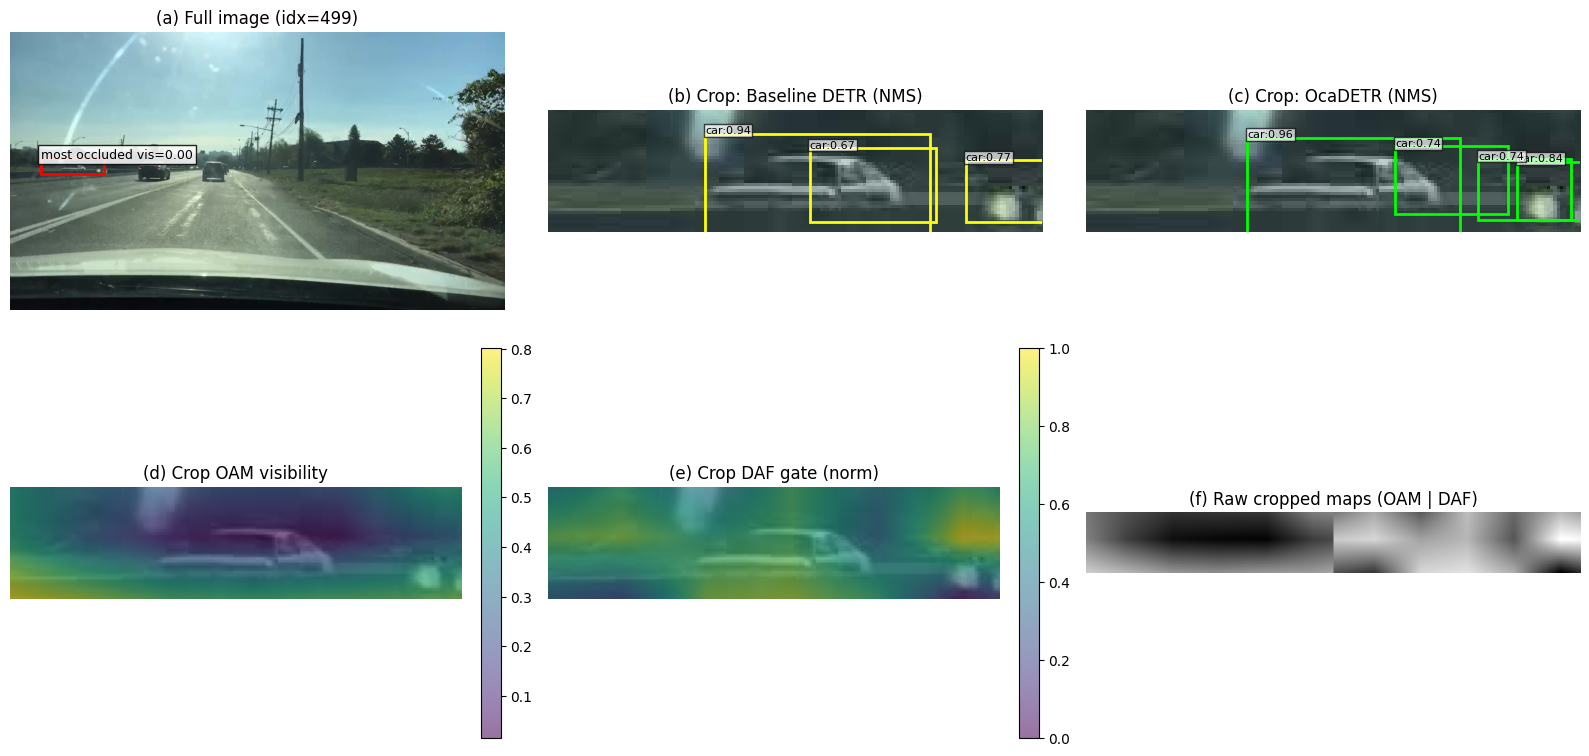

✅ Saved: /kaggle/working/paper_figure_zoom_clean_idx499.png


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

def xywh_to_xyxy_np(b):
    x,y,w,h = b
    return np.array([x, y, x+w, y+h], dtype=np.float32)

def expand_box(xyxy, w, h, scale=1.8):
    x1,y1,x2,y2 = xyxy
    cx, cy = (x1+x2)/2, (y1+y2)/2
    bw, bh = (x2-x1)*scale, (y2-y1)*scale
    nx1 = max(0, cx - bw/2); ny1 = max(0, cy - bh/2)
    nx2 = min(w, cx + bw/2); ny2 = min(h, cy + bh/2)
    return np.array([nx1, ny1, nx2, ny2], dtype=np.float32)

@torch.no_grad()
def paper_zoom_figure(idx, score_thr=0.3, save_path=None):
    img, tgt = val_ds[idx]
    ih, iw = tgt["size"]
    img_np = np.array(img)

    # pick most occluded GT object
    vis = np.array(tgt["visibility"], dtype=np.float32)
    if len(vis) == 0:
        print("No GT objects in this image.")
        return
    j = int(vis.argmin())
    gt_xyxy = xywh_to_xyxy_np(tgt["boxes_xywh"][j])
    crop_xyxy = expand_box(gt_xyxy, iw, ih, scale=2.2)
    x1,y1,x2,y2 = crop_xyxy.astype(int)

    # model inputs
    enc = processor(images=[img], return_tensors="pt")
    pv = enc["pixel_values"].to(DEVICE)
    pm = enc["pixel_mask"].to(DEVICE)

    # baseline pred
    base_out = baseline_detr(pixel_values=pv, pixel_mask=pm)
    base_pred = processor.post_process_object_detection(
        base_out, target_sizes=torch.tensor([[ih, iw]]).to(DEVICE), threshold=score_thr
    )[0]

    # oca pred + maps
    loss, out, extras, _ = oca_model(pv, pm, labels=None, orig_targets=[tgt], lambda_occ=0.0)
    oca_pred = processor.post_process_object_detection(
        out, target_sizes=torch.tensor([[ih, iw]]).to(DEVICE), threshold=score_thr
    )[0]

    vis_map = extras["vis_map"][0,0].float().cpu()
    gate_map = extras["gate"][0,0].float().cpu()

    # upsample maps to image size
    vis_up  = torch.nn.functional.interpolate(vis_map[None,None], size=(ih,iw), mode="bilinear", align_corners=False)[0,0].numpy()
    gate_up = torch.nn.functional.interpolate(gate_map[None,None], size=(ih,iw), mode="bilinear", align_corners=False)[0,0].numpy()

    # crop image + maps
    crop_img  = img_np[y1:y2, x1:x2]
    crop_vis  = vis_up[y1:y2, x1:x2]
    crop_gate = gate_up[y1:y2, x1:x2]

    # helper: draw predictions inside crop
    def draw_preds_on_crop(ax, pred, color):
        boxes = pred["boxes"].cpu().numpy()
        labs  = pred["labels"].cpu().numpy()
        sc    = pred["scores"].cpu().numpy()
        for b,l,s in zip(boxes, labs, sc):
            bx1,by1,bx2,by2 = b
            # skip boxes outside crop
            if bx2 < x1 or bx1 > x2 or by2 < y1 or by1 > y2:
                continue
            # shift into crop coords
            bx1 = max(bx1, x1) - x1
            by1 = max(by1, y1) - y1
            bx2 = min(bx2, x2) - x1
            by2 = min(by2, y2) - y1
            rect = patches.Rectangle((bx1,by1), bx2-bx1, by2-by1, linewidth=2,
                                     edgecolor=color, facecolor="none")
            ax.add_patch(rect)
            ax.text(bx1, by1, f"{BDD_CATS[int(l)]}:{s:.2f}", fontsize=8,
                    bbox=dict(facecolor="white", alpha=0.7, pad=1))

    # plot
    fig, axes = plt.subplots(2, 3, figsize=(16, 8))

    # row 1: full image + crop box
    axes[0,0].imshow(img_np); axes[0,0].axis("off")
    axes[0,0].set_title(f"(a) Full image (idx={idx})")
    rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor="red", facecolor="none")
    axes[0,0].add_patch(rect)
    axes[0,0].text(x1, y1, f"most occluded vis={vis[j]:.2f}", fontsize=9,
                   bbox=dict(facecolor="white", alpha=0.8, pad=2))

    # row 1: crop baseline / crop oca
    axes[0,1].imshow(crop_img); axes[0,1].axis("off")
    axes[0,1].set_title("(b) Crop: Baseline DETR")
    draw_preds_on_crop(axes[0,1], base_pred, "yellow")

    axes[0,2].imshow(crop_img); axes[0,2].axis("off")
    axes[0,2].set_title("(c) Crop: OcaDETR")
    draw_preds_on_crop(axes[0,2], oca_pred, "lime")

    # row 2: overlays
    axes[1,0].imshow(crop_img); hm1 = axes[1,0].imshow(crop_vis, alpha=0.55)
    axes[1,0].axis("off"); axes[1,0].set_title("(d) Crop OAM visibility")
    plt.colorbar(hm1, ax=axes[1,0], fraction=0.046, pad=0.04)

    axes[1,1].imshow(crop_img); hm2 = axes[1,1].imshow(crop_gate, alpha=0.55)
    axes[1,1].axis("off"); axes[1,1].set_title("(e) Crop DAF gate")
    plt.colorbar(hm2, ax=axes[1,1], fraction=0.046, pad=0.04)

    # raw maps crop
    axes[1,2].axis("off"); axes[1,2].set_title("(f) Raw cropped maps (OAM | DAF)")
    combo = np.concatenate([crop_vis, crop_gate], axis=1)
    axes[1,2].imshow(combo, cmap="gray")

    plt.tight_layout()
    if save_path is None:
        save_path = f"/kaggle/working/paper_figure_zoom_idx{idx}.png"
    plt.savefig(save_path, dpi=250)
    plt.show()
    print("✅ Saved:", save_path)

# Example: run on your best occlusion index 499
paper_zoom_figure(idx=499, score_thr=0.3)
paper_zoom_figure(idx=499, score_thr=0.3)



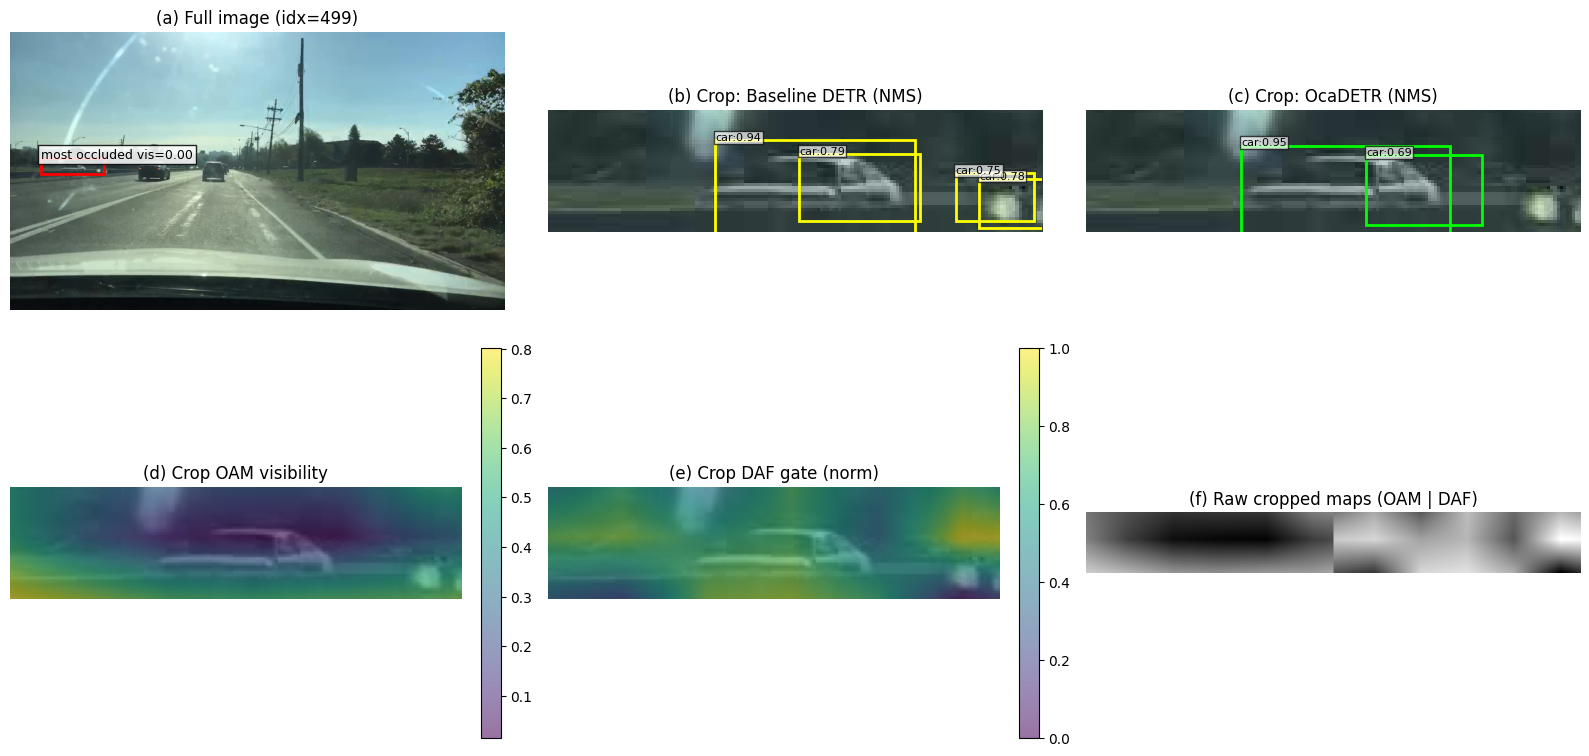

✅ Saved: /kaggle/working/paper_figure_zoom_clean_idx499.png


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision

def xywh_to_xyxy_np(b):
    x,y,w,h = b
    return np.array([x, y, x+w, y+h], dtype=np.float32)

def expand_box(xyxy, w, h, scale=2.2):
    x1,y1,x2,y2 = xyxy
    cx, cy = (x1+x2)/2, (y1+y2)/2
    bw, bh = (x2-x1)*scale, (y2-y1)*scale
    nx1 = max(0, cx - bw/2); ny1 = max(0, cy - bh/2)
    nx2 = min(w, cx + bw/2); ny2 = min(h, cy + bh/2)
    return np.array([nx1, ny1, nx2, ny2], dtype=np.float32)

def nms_filter(pred, iou=0.6, topk=20):
    """Class-wise NMS for cleaner visualization."""
    if len(pred["boxes"]) == 0:
        return pred
    boxes = pred["boxes"]
    scores = pred["scores"]
    labels = pred["labels"]

    keep_all = []
    for c in labels.unique():
        idx = (labels == c).nonzero(as_tuple=True)[0]
        keep = torchvision.ops.nms(boxes[idx], scores[idx], iou)
        keep_all.append(idx[keep])
    keep = torch.cat(keep_all)

    keep = keep[scores[keep].argsort(descending=True)]
    keep = keep[:topk]
    return {"boxes": boxes[keep], "scores": scores[keep], "labels": labels[keep]}

@torch.no_grad()
def paper_zoom_figure(idx, score_thr=0.3, save_path=None,
                     nms_iou=0.6, topk=20, gate_contrast=True, only_gt_class=False):
    img, tgt = val_ds[idx]
    ih, iw = tgt["size"]
    img_np = np.array(img)

    # choose most occluded GT object
    vis = np.array(tgt["visibility"], dtype=np.float32)
    if len(vis) == 0:
        print("No GT objects in this image.")
        return
    j = int(vis.argmin())

    gt_xyxy = xywh_to_xyxy_np(tgt["boxes_xywh"][j])
    crop_xyxy = expand_box(gt_xyxy, iw, ih, scale=2.2)
    x1,y1,x2,y2 = crop_xyxy.astype(int)

    # model input
    enc = processor(images=[img], return_tensors="pt")
    pv = enc["pixel_values"].to(DEVICE)
    pm = enc["pixel_mask"].to(DEVICE)

    # baseline prediction
    base_out = baseline_detr(pixel_values=pv, pixel_mask=pm)
    base_pred = processor.post_process_object_detection(
        base_out, target_sizes=torch.tensor([[ih, iw]]).to(DEVICE), threshold=score_thr
    )[0]

    # oca prediction + maps
    loss, out, extras, _ = oca_model(pv, pm, labels=None, orig_targets=[tgt], lambda_occ=0.0)
    oca_pred = processor.post_process_object_detection(
        out, target_sizes=torch.tensor([[ih, iw]]).to(DEVICE), threshold=score_thr
    )[0]

    # NMS cleanup
    base_pred = nms_filter(base_pred, iou=nms_iou, topk=topk)
    oca_pred  = nms_filter(oca_pred,  iou=nms_iou, topk=topk)

    # optionally show only the GT class in crop
    if only_gt_class and "labels" in tgt:
        gt_class = int(tgt["labels"][j])
        def keep_class(pred, c):
            m = (pred["labels"] == c)
            return {k: v[m] for k, v in pred.items()}
        base_pred = keep_class(base_pred, gt_class)
        oca_pred  = keep_class(oca_pred, gt_class)

    # maps
    vis_map = extras["vis_map"][0,0].float().cpu()
    gate_map = extras["gate"][0,0].float().cpu()

    vis_up  = torch.nn.functional.interpolate(vis_map[None,None], size=(ih,iw), mode="bilinear", align_corners=False)[0,0].numpy()
    gate_up = torch.nn.functional.interpolate(gate_map[None,None], size=(ih,iw), mode="bilinear", align_corners=False)[0,0].numpy()

    crop_img  = img_np[y1:y2, x1:x2]
    crop_vis  = vis_up[y1:y2, x1:x2]
    crop_gate = gate_up[y1:y2, x1:x2]

    # normalize gate just for display contrast
    gate_disp = crop_gate
    if gate_contrast:
        gmin, gmax = float(crop_gate.min()), float(crop_gate.max())
        gate_disp = (crop_gate - gmin) / (gmax - gmin + 1e-6)

    def draw_preds_on_crop(ax, pred, color):
        boxes = pred["boxes"].cpu().numpy()
        labs  = pred["labels"].cpu().numpy()
        sc    = pred["scores"].cpu().numpy()
        for b,l,s in zip(boxes, labs, sc):
            bx1,by1,bx2,by2 = b
            if bx2 < x1 or bx1 > x2 or by2 < y1 or by1 > y2:
                continue
            bx1 = max(bx1, x1) - x1
            by1 = max(by1, y1) - y1
            bx2 = min(bx2, x2) - x1
            by2 = min(by2, y2) - y1
            rect = patches.Rectangle((bx1,by1), bx2-bx1, by2-by1, linewidth=2,
                                     edgecolor=color, facecolor="none")
            ax.add_patch(rect)
            ax.text(bx1, by1, f"{BDD_CATS[int(l)]}:{s:.2f}", fontsize=8,
                    bbox=dict(facecolor="white", alpha=0.7, pad=1))

    fig, axes = plt.subplots(2, 3, figsize=(16, 8))

    # full image + crop region
    axes[0,0].imshow(img_np); axes[0,0].axis("off")
    axes[0,0].set_title(f"(a) Full image (idx={idx})")
    rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor="red", facecolor="none")
    axes[0,0].add_patch(rect)
    axes[0,0].text(x1, y1, f"most occluded vis={vis[j]:.2f}", fontsize=9,
                   bbox=dict(facecolor="white", alpha=0.85, pad=2))

    # crop detections
    axes[0,1].imshow(crop_img); axes[0,1].axis("off")
    axes[0,1].set_title("(b) Crop: Baseline DETR (NMS)")
    draw_preds_on_crop(axes[0,1], base_pred, "yellow")

    axes[0,2].imshow(crop_img); axes[0,2].axis("off")
    axes[0,2].set_title("(c) Crop: OcaDETR (NMS)")
    draw_preds_on_crop(axes[0,2], oca_pred, "lime")

    # overlays
    axes[1,0].imshow(crop_img)
    hm1 = axes[1,0].imshow(crop_vis, alpha=0.55)
    axes[1,0].axis("off")
    axes[1,0].set_title("(d) Crop OAM visibility")
    plt.colorbar(hm1, ax=axes[1,0], fraction=0.046, pad=0.04)

    axes[1,1].imshow(crop_img)
    hm2 = axes[1,1].imshow(gate_disp, alpha=0.55, vmin=0, vmax=1 if gate_contrast else None)
    axes[1,1].axis("off")
    axes[1,1].set_title("(e) Crop DAF gate" + (" (norm)" if gate_contrast else ""))
    plt.colorbar(hm2, ax=axes[1,1], fraction=0.046, pad=0.04)

    # raw cropped maps
    axes[1,2].axis("off")
    axes[1,2].set_title("(f) Raw cropped maps (OAM | DAF)")
    combo = np.concatenate([crop_vis, gate_disp], axis=1)
    axes[1,2].imshow(combo, cmap="gray")

    plt.tight_layout()
    if save_path is None:
        save_path = f"/kaggle/working/paper_figure_zoom_clean_idx{idx}.png"
    plt.savefig(save_path, dpi=250)
    plt.show()
    print("✅ Saved:", save_path)

# Example
paper_zoom_figure(idx=499, score_thr=0.3)


In [39]:
import torchvision

def nms_filter(pred, iou=0.6, topk=30):
    if len(pred["boxes"]) == 0:
        return pred
    boxes = pred["boxes"]
    scores = pred["scores"]
    labels = pred["labels"]

    keep_all = []
    for c in labels.unique():
        idx = (labels == c).nonzero(as_tuple=True)[0]
        k = torchvision.ops.nms(boxes[idx], scores[idx], iou)
        keep_all.append(idx[k])

    keep = torch.cat(keep_all)
    keep = keep[scores[keep].argsort(descending=True)]
    keep = keep[:topk]

    return {
        "boxes": boxes[keep],
        "scores": scores[keep],
        "labels": labels[keep]
    }


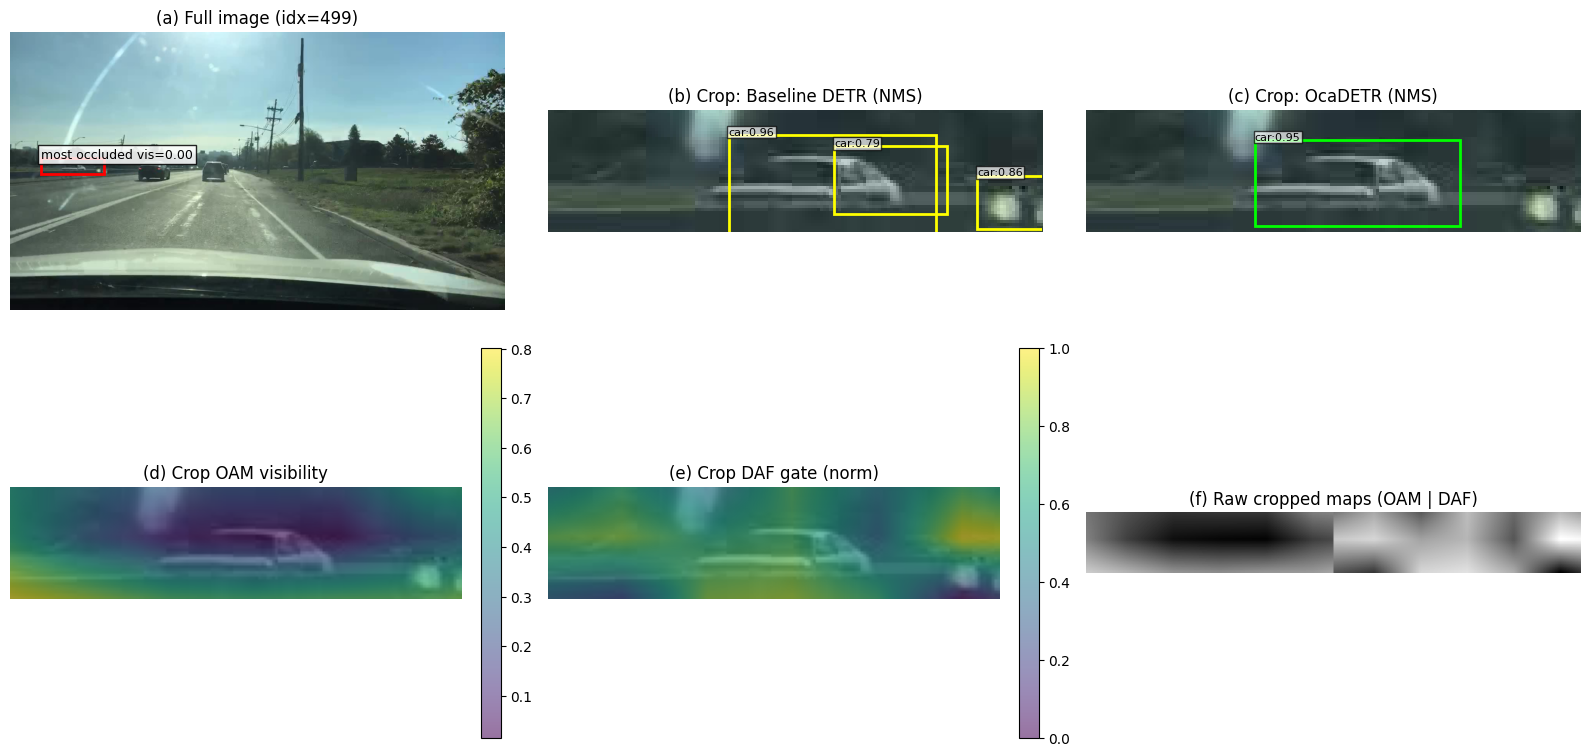

✅ Saved: /kaggle/working/Fig6a_occlusion_zoom_idx499.png


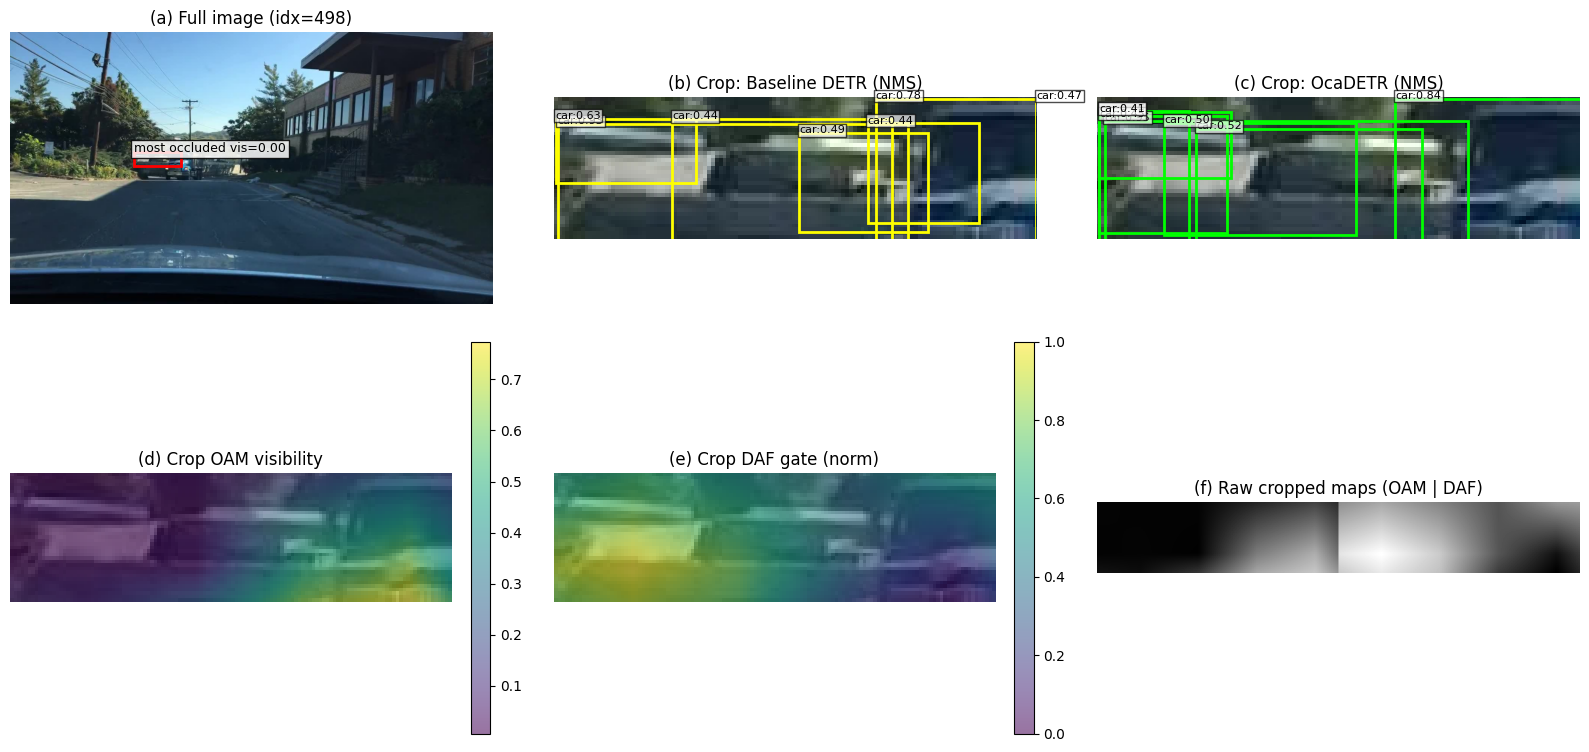

✅ Saved: /kaggle/working/Fig6b_occlusion_zoom_idx498.png


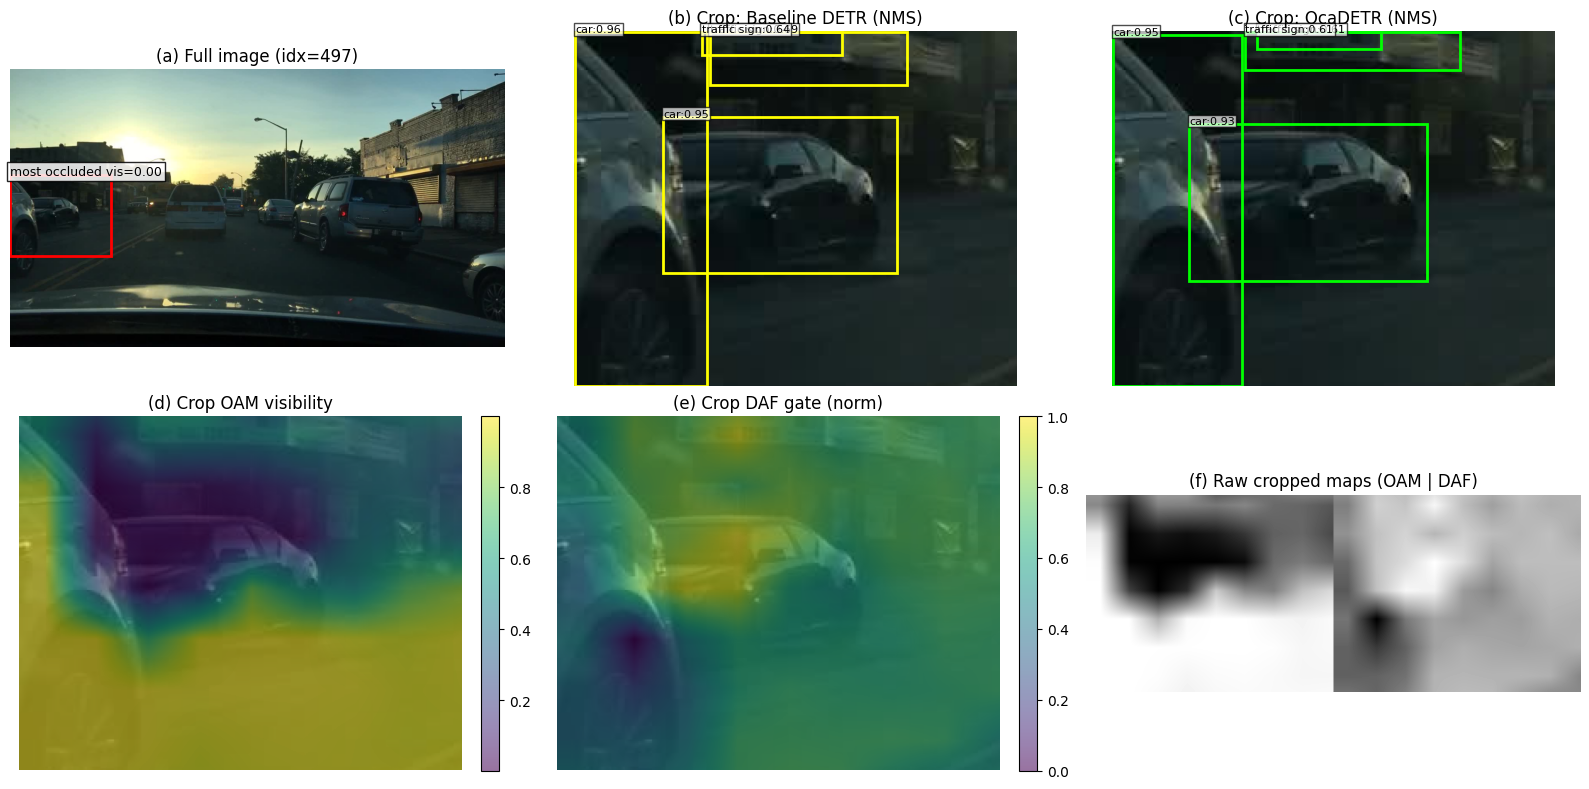

✅ Saved: /kaggle/working/Fig6c_occlusion_zoom_idx497.png
✅ Saved Fig6a/Fig6b/Fig6c in /kaggle/working


In [41]:
# pick top-3 most occluded val images and export as Fig6a/b/c
best3 = best_indices if "best_indices" in globals() else [499, 0, 1]

names = ["Fig6a", "Fig6b", "Fig6c"]
for name, idx in zip(names, best3[:3]):
    out_path = f"/kaggle/working/{name}_occlusion_zoom_idx{idx}.png"
    paper_zoom_figure(idx=idx, score_thr=0.3, save_path=out_path,
                      nms_iou=0.6, topk=15, gate_contrast=True)
print("✅ Saved Fig6a/Fig6b/Fig6c in /kaggle/working")
